### Import

In [30]:
import pandas as pd
import numpy as np
import os
import random

from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
CFG = {
    'NBITS':2048,
    'SEED':42,
}

In [32]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG['SEED']) # Seed 고정

### DataLoad

In [33]:
# 학습 ChEMBL 데이터 로드
chembl_data = pd.read_csv('../rdkit_data/rdkit_train_corr_0.45.csv')  # 예시 파일 이름
chembl_data.head()

,pIC50,NumValenceElectrons,Chi0,Chi0n,Chi2n,Kappa1,fr_pyridine
0,10.59,206,27.310826,22.307719,11.341360,25.694355,0
1,10.11,206,27.310826,22.008861,10.947914,25.656488,0
2,10.09,208,27.896612,21.649435,10.412358,26.879586,0
3,10.00,218,29.103719,22.856542,11.674656,27.459394,0
4,10.00,180,24.156125,19.769469,9.519913,21.574464,0


In [34]:
target = ['pIC50']
x = chembl_data.drop(target, axis = 1)
y = chembl_data.loc[:, target]

# 학습 및 검증 데이터 분리
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.3, random_state=42)

### Train & Validation

In [35]:
# 랜덤 포레스트 모델 학습
model = RandomForestRegressor(random_state=CFG['SEED'])

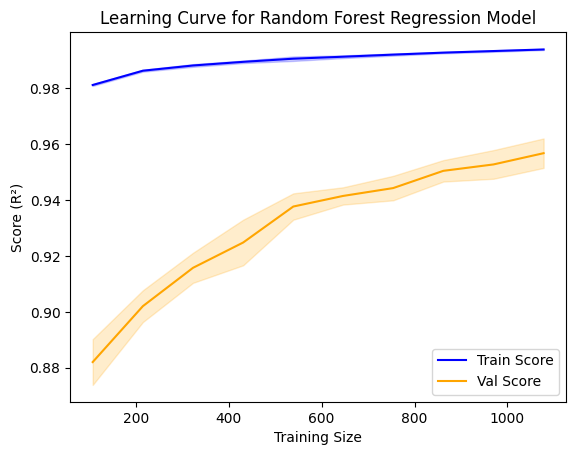

In [36]:
# 학습 곡선 계산
train_sizes, train_scores, val_scores = learning_curve(model, train_x, train_x, cv=5, 
                                                         n_jobs=-1, 
                                                         train_sizes=np.linspace(0.1, 1.0, 10))

# 평균 및 표준편차 계산
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# 시각화
plt.plot(train_sizes, train_mean, label='Train Score', color='blue')
plt.plot(train_sizes, val_mean, label='Val Score', color='orange')

# 신뢰구간 표시
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)

plt.title('Learning Curve for Random Forest Regression Model')
plt.xlabel('Training Size')
plt.ylabel('Score (R²)')
plt.legend()
plt.show()

In [40]:
model.fit(train_x, train_y)

c:\Users\ogong\anaconda3\envs\dacon\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [21]:
# pIC50에서 IC50을 계산하는 함수
def pIC50_to_IC50(pic50_values):
    """Convert pIC50 values to IC50 (nM)."""
    return 10 ** (9 - pic50_values)

# Normalized RMSE를 계산하는 함수
def calculate_normalized_rmse(true_pIC50, predicted_pIC50):
    """
    Normalized RMSE 계산.
    Normalized RMSE = RMSE / (max(true_IC50) - min(true_IC50))
    """
    # RMSE 계산
    mse = mean_squared_error(pIC50_to_IC50(true_pIC50), pIC50_to_IC50(predicted_pIC50))
    rmse = np.sqrt(mse)
    # Normalized RMSE 계산
    norm_rmse = rmse / (np.max(pIC50_to_IC50(true_pIC50)) - np.min(pIC50_to_IC50(predicted_pIC50)))
    return norm_rmse

# pIC50에서 Correct Ratio를 계산하는 함수
def calculate_correct_ratio(true_pIC50, predicted_pIC50):
    """
    Correct Ratio 계산.
    Correct Ratio = 1/N * Σ I(Absolute Error <= 0.5)
    """
    # 절대 오차 계산
    abs_errors = np.abs(predicted_pIC50 - true_pIC50)
    # 절대 오차가 0.5 이하인 경우의 수 계산
    correct_count = np.sum(abs_errors <= 0.5)
    # Correct Ratio 계산
    correct_ratio = correct_count / len(true_pIC50)
    return correct_ratio

# 최종 Score를 계산하는 함수
def calculate_score(true_pIC50, predicted_pIC50):
    """
    주어진 실제 IC50 값과 예측 IC50 값을 기반으로 Score 계산.
    Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    """
    # Normalized RMSE 계산 (A 값)
    norm_rmse = calculate_normalized_rmse(true_pIC50, predicted_pIC50)

    # Correct Ratio 계산 (B 값)
    correct_ratio = calculate_correct_ratio(true_pIC50, predicted_pIC50)

    # 최종 Score 계산
    # Score = 0.5 * (1 - min(Normalized RMSE, 1)) + 0.5 * Correct Ratio
    score = 0.5 * (1 - min(norm_rmse, 1)) + 0.5 * correct_ratio
    
    return score

In [43]:
val_y_pred = model.predict(val_x)
val_y = np.array(val_y)
val_y = val_y.ravel()

In [44]:
r2 = r2_score(val_y, val_y_pred)
print(r2)

0.40674536481836143


In [46]:
norm_rmse = calculate_normalized_rmse(val_y, val_y_pred)
correct_ratio = calculate_correct_ratio(val_y, val_y_pred)
score = calculate_score(val_y, val_y_pred)
print(f"norm_rmse: {norm_rmse:.4f}")
print(f"correct_ratio: {correct_ratio:.4f}")
print(f"Calculated Score: {score:.4f}")

norm_rmse: 0.0809
correct_ratio: 0.5398
Calculated Score: 0.7295


In [8]:
print(model.feature_importances_, '\n')

# 시리즈로 만들어 인덱스를 붙인다
ser = pd.Series(model.feature_importances_, index=x.columns)

# 내림차순 정렬을 이용한다
top = ser.sort_values(ascending=False)[:]
print(top)

[0.07487802 0.24157832 0.14596108 0.23668087 0.20003839 0.10086332] 

Chi0                   0.241578
Chi2n                  0.236681
Kappa1                 0.200038
Chi0n                  0.145961
fr_pyridine            0.100863
NumValenceElectrons    0.074878
dtype: float64


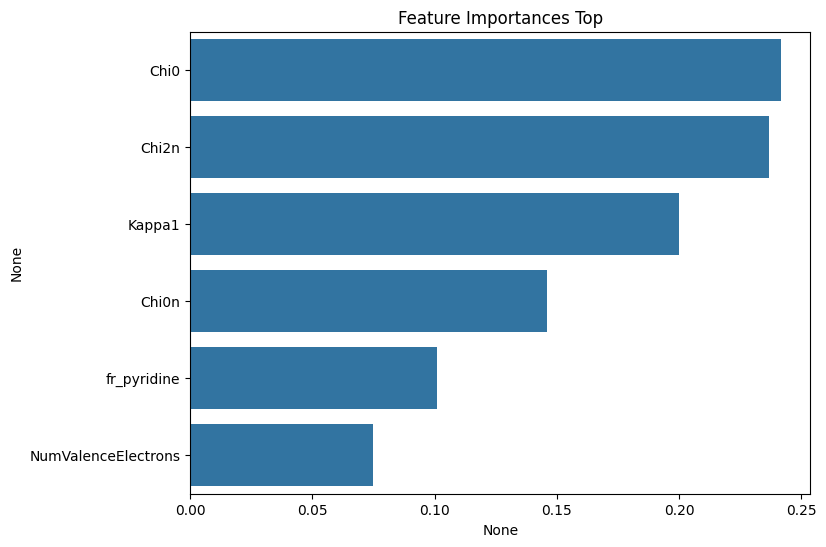

In [9]:
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top')
sns.barplot(x=top, y=top.index)
plt.show()

### Inference

In [10]:
test = pd.read_csv('../rdkit_data/rdkit_test_corr_0.45.csv')

test_y_pred = model.predict(test)

### Submission

In [11]:
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = pIC50_to_IC50(test_y_pred)
submit.head()

,ID,IC50_nM
0,TEST_000,28.980108
1,TEST_001,7.416517
2,TEST_002,191.146639
3,TEST_003,7.316443
4,TEST_004,122.283164


In [12]:
submit.to_csv('./corr_0.45_submit.csv', index=False)